# Notebook for Supervised ML: Predicting dynamics

This is the notebook for the Lorenz system.

In [3]:
# --------------------- Import necessary libraries ---------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# --------------------- Simulate Lorenz system and plot data ---------------------
# Lorenz system parameters
sigma = 10.0
beta = 8/3
rho = 28.0

# Lorenz ODE system
def lorenz_ode(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial condition and time setup
t_span = (0, 2)
t_eval = np.linspace(*t_span, 100)
initial_state = [4.0, 3.0, 19.0]

# Simulate trajectory
sol = solve_ivp(lorenz_ode, t_span, initial_state, t_eval=t_eval, method='RK45')
x, y, z = sol.y

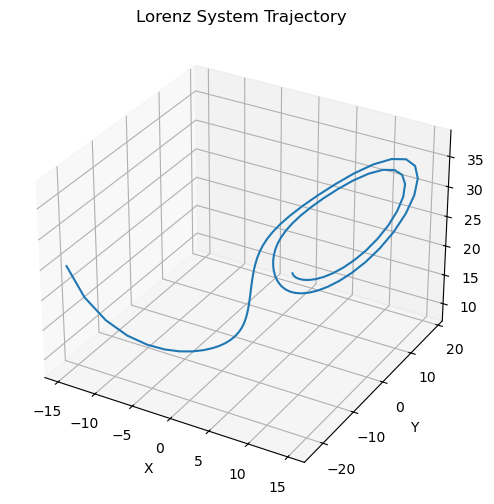

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # even if unused, triggers proper backend loading

# Plot Lorenz trajectory
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_title('Lorenz System Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

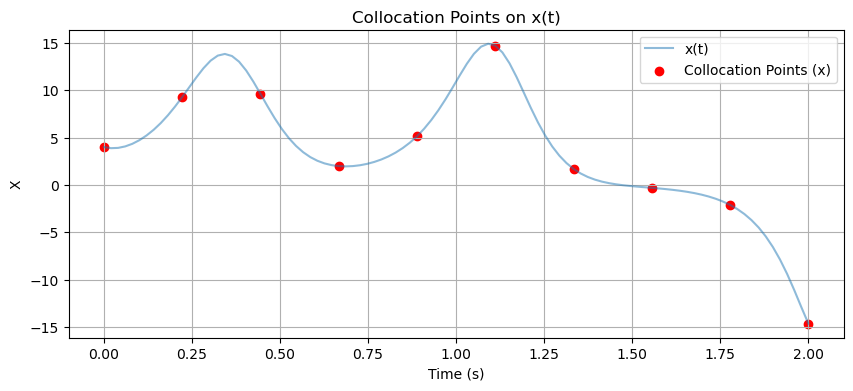

In [9]:
# Select collocation points
num_collocation = 10
collocation_idx = np.linspace(0, len(t_eval)-1, num_collocation, dtype=int)

t_collocation = t_eval[collocation_idx]
x_collocation = x[collocation_idx]
y_collocation = y[collocation_idx]
z_collocation = z[collocation_idx]

# Plot collocation points on X(t)
plt.figure(figsize=(10, 4))
plt.plot(t_eval, x, label='x(t)', alpha=0.5)
plt.scatter(t_collocation, x_collocation, color='red', label='Collocation Points (x)')
plt.xlabel('Time (s)')
plt.ylabel('X')
plt.title('Collocation Points on x(t)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Hyperparameters
epochs = 30000

In [29]:
# Prepare training data (collocation points)
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(np.vstack([x_collocation, y_collocation, z_collocation]).T, dtype=torch.float32)

# Define the network
class LorenzNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )
        
    def forward(self, t):
        return self.net(t)

In [31]:
# Instantiate model, optimizer and loss
model = LorenzNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 237.698990
Epoch 1000, Loss: 32.800629
Epoch 2000, Loss: 24.149830
Epoch 3000, Loss: 20.234556
Epoch 4000, Loss: 19.026358
Epoch 5000, Loss: 15.647093
Epoch 6000, Loss: 12.838629
Epoch 7000, Loss: 11.593531
Epoch 8000, Loss: 10.842389
Epoch 9000, Loss: 10.361747
Epoch 10000, Loss: 10.060640
Epoch 11000, Loss: 7.867682
Epoch 12000, Loss: 3.514443
Epoch 13000, Loss: 1.808235
Epoch 14000, Loss: 0.882464
Epoch 15000, Loss: 0.372575
Epoch 16000, Loss: 0.123800
Epoch 17000, Loss: 0.027835
Epoch 18000, Loss: 0.003476
Epoch 19000, Loss: 0.000202
Epoch 20000, Loss: 0.000054
Epoch 21000, Loss: 0.000000
Epoch 22000, Loss: 0.000013
Epoch 23000, Loss: 0.000003
Epoch 24000, Loss: 0.000016
Epoch 25000, Loss: 0.000004
Epoch 26000, Loss: 0.000006
Epoch 27000, Loss: 0.000022
Epoch 28000, Loss: 0.000000
Epoch 29000, Loss: 0.000001


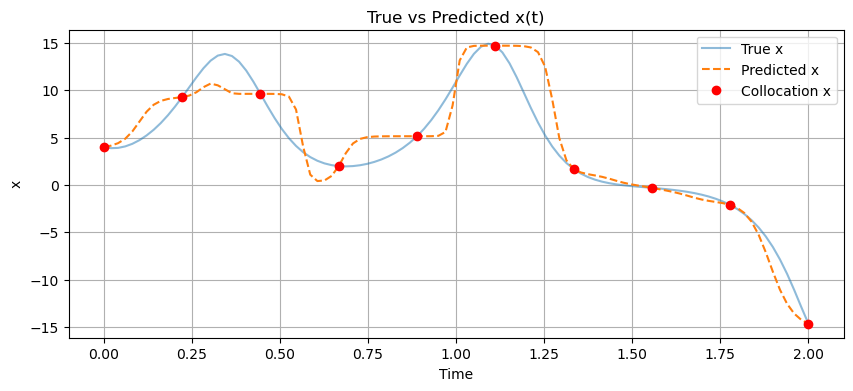

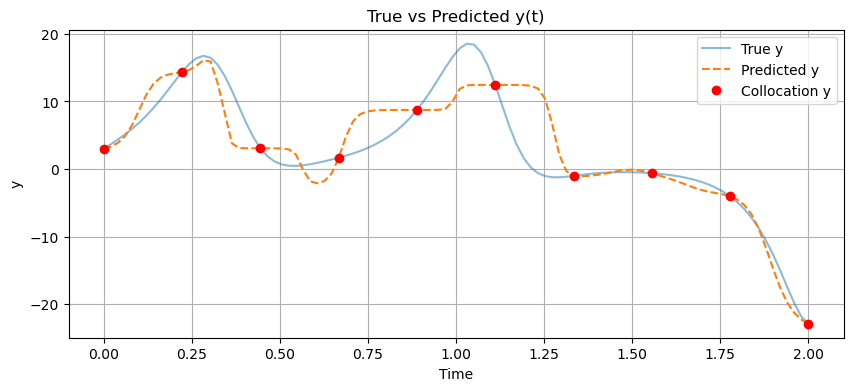

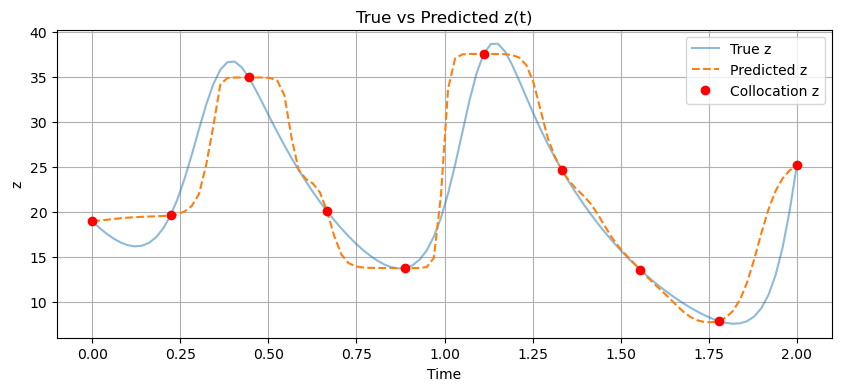

In [41]:
# Evaluate model on full time range
t_all = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    pred_all = model(t_all).numpy()

pred_vanilla = pred_all

# Plot predictions vs. true values for x(t)
plt.figure(figsize=(10, 4))
plt.plot(t_eval, x, label='True x', alpha=0.5)
plt.plot(t_eval, pred_all[:, 0], '--', label='Predicted x')
plt.plot(t_collocation, x_collocation, 'ro', label='Collocation x')  # <-- added
plt.xlabel('Time')
plt.ylabel('x')
plt.title('True vs Predicted x(t)')
plt.legend()
plt.grid(True)
plt.show()

# Plot y(t)
plt.figure(figsize=(10, 4))
plt.plot(t_eval, y, label='True y', alpha=0.5)
plt.plot(t_eval, pred_all[:, 1], '--', label='Predicted y')
plt.plot(t_collocation, y_collocation, 'ro', label='Collocation y')  # <-- added
plt.xlabel('Time')
plt.ylabel('y')
plt.title('True vs Predicted y(t)')
plt.legend()
plt.grid(True)
plt.show()

# Plot z(t)
plt.figure(figsize=(10, 4))
plt.plot(t_eval, z, label='True z', alpha=0.5)
plt.plot(t_eval, pred_all[:, 2], '--', label='Predicted z')
plt.plot(t_collocation, z_collocation, 'ro', label='Collocation z')  # <-- added
plt.xlabel('Time')
plt.ylabel('z')
plt.title('True vs Predicted z(t)')
plt.legend()
plt.grid(True)
plt.show()


## PINN

In [43]:
# Convert to torch tensors
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1).requires_grad_()
x_true = torch.tensor(x[collocation_idx], dtype=torch.float32).unsqueeze(1)
y_true = torch.tensor(y[collocation_idx], dtype=torch.float32).unsqueeze(1)
z_true = torch.tensor(z[collocation_idx], dtype=torch.float32).unsqueeze(1)

In [53]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, t):
        return self.net(t)

model = PINN()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)
loss_fn = nn.MSELoss()

In [55]:
# ---------------- Training Loop ---------------- #
epochs = 15000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    pred = model(t_train)
    x_pred, y_pred, z_pred = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

    # Compute time derivatives
    dxdt = torch.autograd.grad(x_pred, t_train, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]
    dydt = torch.autograd.grad(y_pred, t_train, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    dzdt = torch.autograd.grad(z_pred, t_train, grad_outputs=torch.ones_like(z_pred), create_graph=True)[0]

    # Physics-informed residuals
    res1 = dxdt - sigma * (y_pred - x_pred)
    res2 = dydt - (x_pred * (rho - z_pred) - y_pred)
    res3 = dzdt - (x_pred * y_pred - beta * z_pred)
    physics_loss = (res1**2 + res2**2 + res3**2).mean()

    # Data loss from observations
    data_loss = loss_fn(x_pred, x_true) + loss_fn(y_pred, y_true) + loss_fn(z_pred, z_true)

    # Total loss
    loss = data_loss + physics_loss
    
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f} | Data = {data_loss.item():.6f} | Physics = {physics_loss.item():.6f}")

Epoch 0: Total Loss = 720.636902 | Data = 714.235352 | Physics = 6.401533
Epoch 500: Total Loss = 550.775940 | Data = 515.286987 | Physics = 35.488979
Epoch 1000: Total Loss = 409.618378 | Data = 389.631317 | Physics = 19.987070
Epoch 1500: Total Loss = 213.804886 | Data = 208.134094 | Physics = 5.670789
Epoch 2000: Total Loss = 129.100739 | Data = 126.751495 | Physics = 2.349242
Epoch 2500: Total Loss = 87.341949 | Data = 86.653900 | Physics = 0.688046
Epoch 3000: Total Loss = 45.048897 | Data = 44.692982 | Physics = 0.355915
Epoch 3500: Total Loss = 28.634880 | Data = 28.505543 | Physics = 0.129338
Epoch 4000: Total Loss = 20.135427 | Data = 19.951241 | Physics = 0.184188
Epoch 4500: Total Loss = 15.112391 | Data = 15.049918 | Physics = 0.062472
Epoch 5000: Total Loss = 11.676957 | Data = 11.639652 | Physics = 0.037305
Epoch 5500: Total Loss = 8.945624 | Data = 8.897196 | Physics = 0.048428
Epoch 6000: Total Loss = 7.384193 | Data = 6.748902 | Physics = 0.635291
Epoch 6500: Total Los

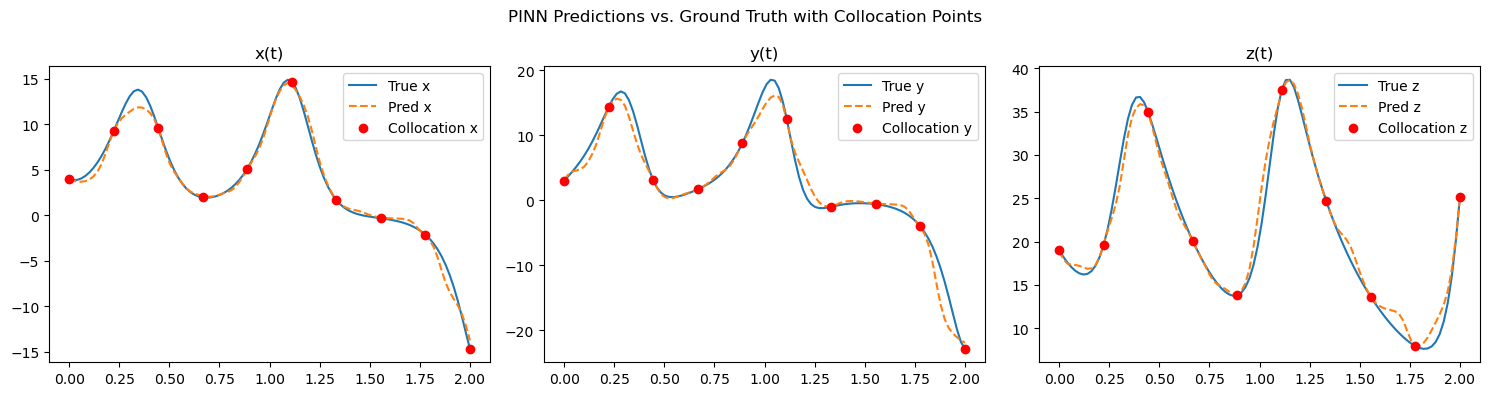

In [60]:
# ---------------- Evaluation ---------------- #
t_tensor = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    pred = model(t_tensor).numpy()
    pred_pinn = pred
    x_pred, y_pred, z_pred = pred[:, 0], pred[:, 1], pred[:, 2]

# ---------------- Plotting ---------------- #
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# x(t)
axs[0].plot(t_eval, x, label='True x')
axs[0].plot(t_eval, x_pred, '--', label='Pred x')
axs[0].scatter(t_collocation, x_true.detach().numpy(), color='red', label='Collocation x', zorder=5)
axs[0].set_title("x(t)")
axs[0].legend()

# y(t)
axs[1].plot(t_eval, y, label='True y')
axs[1].plot(t_eval, y_pred, '--', label='Pred y')
axs[1].scatter(t_collocation, y_true.detach().numpy(), color='red', label='Collocation y', zorder=5)
axs[1].set_title("y(t)")
axs[1].legend()

# z(t)
axs[2].plot(t_eval, z, label='True z')
axs[2].plot(t_eval, z_pred, '--', label='Pred z')
axs[2].scatter(t_collocation, z_true.detach().numpy(), color='red', label='Collocation z', zorder=5)
axs[2].set_title("z(t)")
axs[2].legend()

plt.suptitle("PINN Predictions vs. Ground Truth with Collocation Points")
plt.tight_layout()
plt.show()


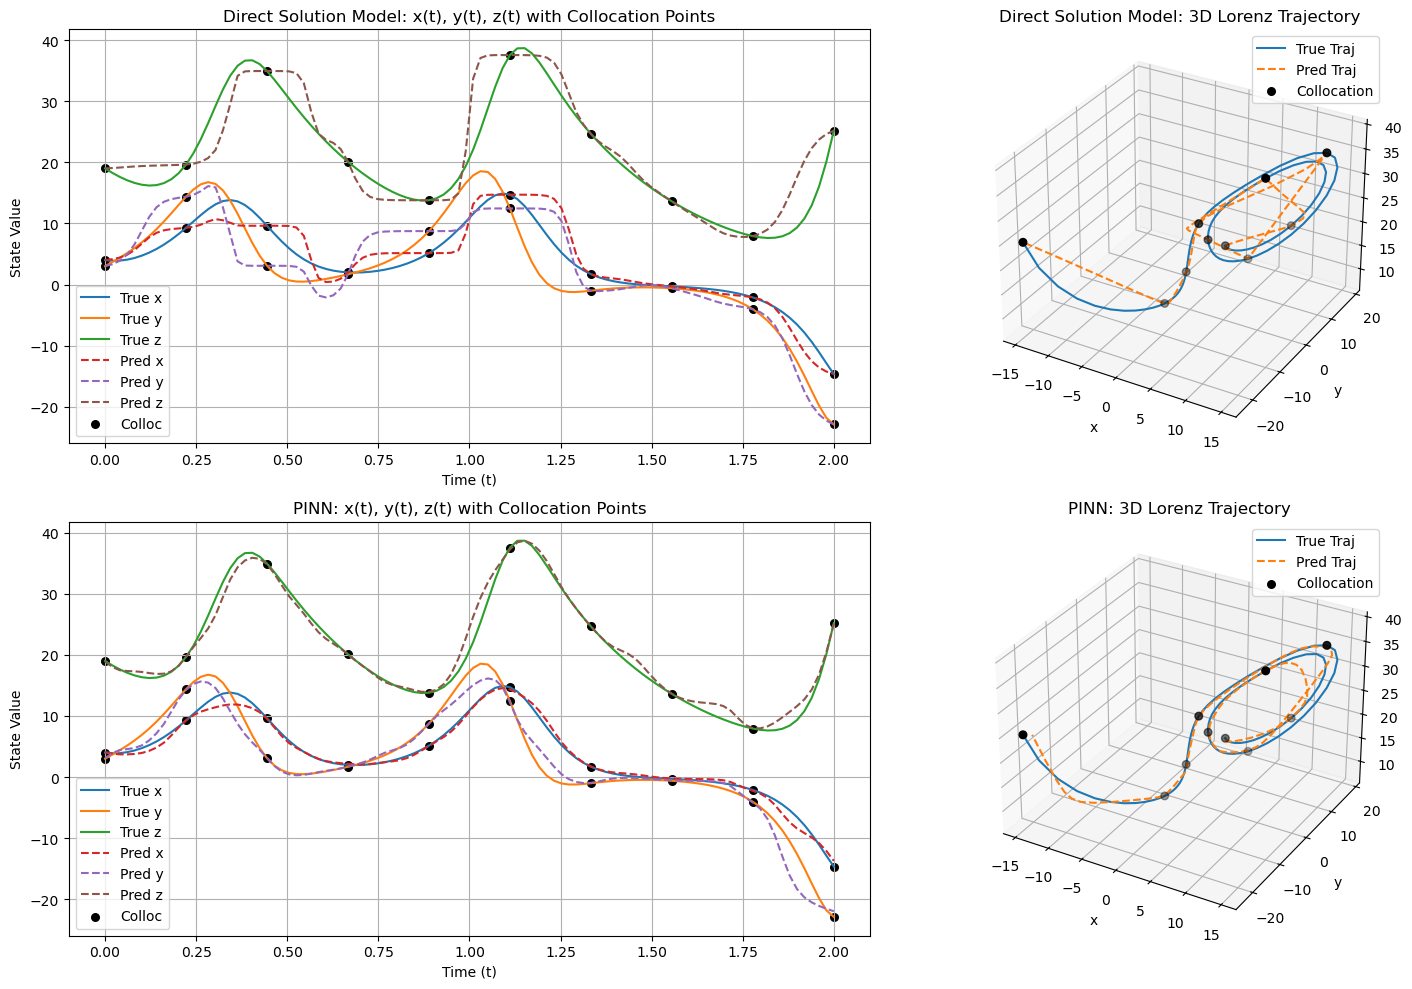

In [82]:
# ---------------- Evaluation ---------------- #
t_tensor = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    # Model predictions
    pred_van = pred_vanilla  # shape: [N, 3]
    pred_pin = pred_pinn     # shape: [N, 3]

# ---------------- Combined Plot (2 rows) ---------------- #
fig = plt.figure(figsize=(16, 10))

# -------- First Row: Direct Solution Model -------- #
# Time-series plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t_eval, x, label='True x')
ax1.plot(t_eval, y, label='True y')
ax1.plot(t_eval, z, label='True z')
ax1.plot(t_eval, pred_van[:, 0], '--', label='Pred x')
ax1.plot(t_eval, pred_van[:, 1], '--', label='Pred y')
ax1.plot(t_eval, pred_van[:, 2], '--', label='Pred z')

# Collocation points (black)
ax1.scatter(t_collocation, x_true.detach().numpy(), color='black', marker='o', s=30, label='Colloc')
ax1.scatter(t_collocation, y_true.detach().numpy(), color='black', marker='o', s=30)
ax1.scatter(t_collocation, z_true.detach().numpy(), color='black', marker='o', s=30)

ax1.set_xlabel("Time (t)")
ax1.set_ylabel("State Value")
ax1.set_title("Direct Solution Model: x(t), y(t), z(t) with Collocation Points")
ax1.legend()
ax1.grid(True)

# 3D trajectory plot
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot(x, y, z, label='True Traj', linewidth=1.5)
ax2.plot(pred_van[:, 0], pred_van[:, 1], pred_van[:, 2], '--', label='Pred Traj', linewidth=1.5)

# Collocation points (black)
ax2.scatter(x_true.detach().numpy(), y_true.detach().numpy(), z_true.detach().numpy(),
            color='black', label='Collocation', s=30)

ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("Direct Solution Model: 3D Lorenz Trajectory")
ax2.legend()

# -------- Second Row: PINN Model -------- #
# Time-series plot
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(t_eval, x, label='True x')
ax3.plot(t_eval, y, label='True y')
ax3.plot(t_eval, z, label='True z')
ax3.plot(t_eval, pred_pin[:, 0], '--', label='Pred x')
ax3.plot(t_eval, pred_pin[:, 1], '--', label='Pred y')
ax3.plot(t_eval, pred_pin[:, 2], '--', label='Pred z')

# Collocation points (black)
ax3.scatter(t_collocation, x_true.detach().numpy(), color='black', marker='o', s=30, label='Colloc')
ax3.scatter(t_collocation, y_true.detach().numpy(), color='black', marker='o', s=30)
ax3.scatter(t_collocation, z_true.detach().numpy(), color='black', marker='o', s=30)

ax3.set_xlabel("Time (t)")
ax3.set_ylabel("State Value")
ax3.set_title("PINN: x(t), y(t), z(t) with Collocation Points")
ax3.legend()
ax3.grid(True)

# 3D trajectory plot
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot(x, y, z, label='True Traj', linewidth=1.5)
ax4.plot(pred_pin[:, 0], pred_pin[:, 1], pred_pin[:, 2], '--', label='Pred Traj', linewidth=1.5)

# Collocation points (black)
ax4.scatter(x_true.detach().numpy(), y_true.detach().numpy(), z_true.detach().numpy(),
            color='black', label='Collocation', s=30)

ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
ax4.set_title("PINN: 3D Lorenz Trajectory")
ax4.legend()

plt.tight_layout()
plt.savefig("lorenz_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


## Predict unseen data

In [70]:
# New prediction interval: t = 2 to t = 3
t_future = np.linspace(2, 2.1, 100)
t_future_tensor = torch.tensor(t_future, dtype=torch.float32).unsqueeze(1)

# Model prediction on future time
with torch.no_grad():
    pred_future = model(t_future_tensor).numpy()
    x_future_pred = pred_future[:, 0]
    y_future_pred = pred_future[:, 1]
    z_future_pred = pred_future[:, 2]

In [72]:
# Simulate true trajectory from t = 2 to t = 3 using last state from previous integration
initial_future_state = sol.y[:, -1]  # state at t=2
sol_future = solve_ivp(lorenz_ode, (2, 3), initial_future_state, t_eval=t_future, method='RK45')
x_future_true, y_future_true, z_future_true = sol_future.y

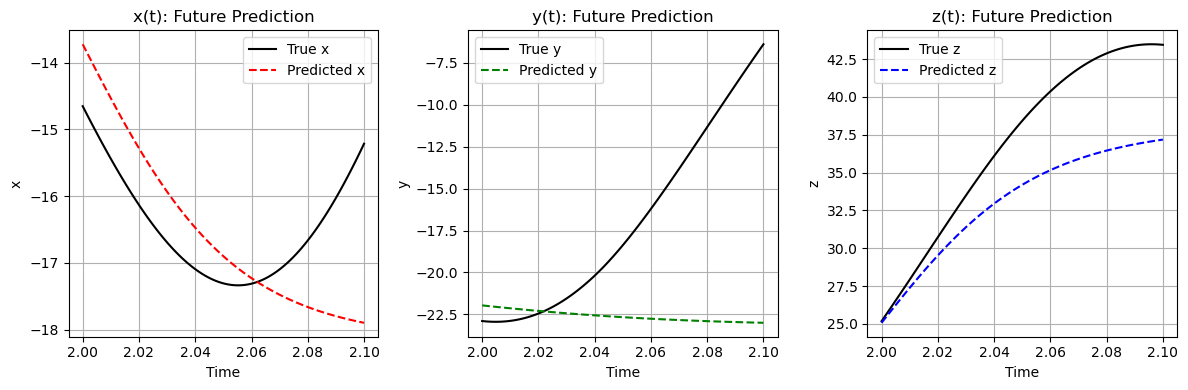

In [74]:
plt.figure(figsize=(12, 4))

# x(t)
plt.subplot(1, 3, 1)
plt.plot(t_future, x_future_true, label='True x', color='black')
plt.plot(t_future, x_future_pred, '--', label='Predicted x', color='red')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('x(t): Future Prediction')
plt.legend()
plt.grid(True)

# y(t)
plt.subplot(1, 3, 2)
plt.plot(t_future, y_future_true, label='True y', color='black')
plt.plot(t_future, y_future_pred, '--', label='Predicted y', color='green')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('y(t): Future Prediction')
plt.legend()
plt.grid(True)

# z(t)
plt.subplot(1, 3, 3)
plt.plot(t_future, z_future_true, label='True z', color='black')
plt.plot(t_future, z_future_pred, '--', label='Predicted z', color='blue')
plt.xlabel('Time')
plt.ylabel('z')
plt.title('z(t): Future Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()